# 3. Modeling

#### Alfredo Di Massimo

#### BrainStation, Data Science

#### April 4th, 2022

___

Having prepared our data in previous notebooks for machine learning, this notebook will deploy classification models to be able to predict the sentiment behind a review as either "bad" or "good". I will be testing the following models specifically:

1. Logistic Regression
2. Decision Tree Classifier
3. XGBClassifier

Given that the reviews are in text format, we will need to transform the data into numeric form to be able to feed it into our models. This will be done using the following tools:

1. Bag of Words
2. Term Frequency-Inverse Document Frequency (TF-IDF)

In order to better understand the factors that can increase the likelihood of a movie being rated as "good" or "bad", we will make use of stopwords in our tokenization step. This will inhibit words with inherently positive or negative meanings (ex: "great" & "horrible") from appearing in our analysis as they provide no actual insight into what makes a movie successful.

In addition to this, we will explore both stemming and lemmatization, two word normalization techniques. Both are techniques that find the root form of a given word with their own advantages and disadvantages:
- **Stemming**: While significantly simpler and computationally efficient, stemming can lead to a higher number of errors and misspellings;
- **Lemmatization**: Considers the context of a word and converts it to a meaningful base form, however is much more complex and cimputationally expensive.

Given the dataset is not too large, we will apply lemmatization to produce more accurate findings.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import joblib
import dill as pickle
import pickle

# Text data packages
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Classifiers 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Model Selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Evaluation 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

# Other required packages
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load in the data
movies = joblib.load('movies.pkl')
movies.head()

,primaryTitle,runtimeMinutes,numVotes,sentiment,review,review_word_count,Action,Adult,Adventure,Animation,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,The Student of Prague,85,2054,1,"A good film, and one I'll watch a number of ti...",172,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Student of Prague,85,2054,1,"In this truly fascinating, dark film, a young ...",292,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Student of Prague,85,2054,1,This early version of the tale 'The Student of...,142,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The Student of Prague,85,2054,1,Those engaging the movie camera so early in th...,165,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Student of Prague,85,2054,1,A stupid young man becomes obsessed with a wom...,184,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
movies.shape

(25049, 30)

## Machine Learning Workflow

We will clearly outline the steps taken throughout this notebook, defining our workflow in order to ultimately develop an accurate model that will allow us to extract, score, classify and visualize the thoughts behind the reviews left by movie-goers within our dataset:

1. Creating a function for advanced tokenization - this will be applied to both vectorizers later for advanced tokenization of the text
2. Preparing data and applying Helper Function
3. Performing a train-test split on the data
4. Establish a baseline model
5. Fit our machine learning models <br/>
    5.1 Fitting Logistic Regression and DecisionTreeClassifier using GridSearch CV
    5.2 Evaluate our best model
    5.3 Fitting XGBoost using RandomizedSearchCV
    5.4 Evaluate the XGBoost

___

### 1. Create custom tokenizer

Our custom tokenizer will be applied to both the Bag of Words and TF-IDF vectorizers, applying the tokenization features we will define below. The goal of the tokenizer is to minimize the number of words kept after vecotrization so that only words that can provide us insight into what is important to reviewers remain for analysis.

In [4]:
# Load in list of stopwords (found in appendix)
stopwords = joblib.load('stopwords.pkl')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in stopwords) and (word!=''):
            # Lemmatize words
            lemmatizer = WordNetLemmatizer()
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

### 2. Preparing data and applying Helper Function

The function below (originally defined by [Allistair Cota](https://github.com/allistaircota/rate_my_restaurant/blob/main/notebooks/NB3-Modelling.ipynb) and modified to factor out text data not being analyzed by [Andrew Dang](https://github.com/andrew-dang/whisky_predictions/blob/main/3_Modeling.ipynb)) allows us to apply multiple vectorizers to our text data returning a sparse matrix based on the specified vectorizer.

In [5]:
text_data = movies['review']
numeric_data = movies.drop(['review'], axis=1) #primaryTitle will be dropped shortly as we are not including it in our analysis

# We must pass column names as arguments into the ColumnTransformer
num_cols = numeric_data.columns.tolist()
num_cols

['primaryTitle',
 'runtimeMinutes',
 'numVotes',
 'sentiment',
 'review_word_count',
 'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [6]:
def define_col_trans(input_text, vectorizer):
    '''
    Returns a ColumnTransformer which first performs a 
    passthrough on the numeric columns, then applies
    a vectorizer on the `text` column
    
    PARAMETERS:
    - input_text: str, to name the vectorizer tuple
    - vectorizer: Sklearn text vectorizer
    
    RETURNS:
    - col_trans: sklearn ColumnTransformer
    
    '''
    
    # Vectorize text data (cleaned_reviews column) and let everything else pass through
    
    col_trans = ColumnTransformer([
        (input_text, vectorizer, 'review')
    ], 
        remainder='passthrough', 
        sparse_threshold=0)
    
    return col_trans

In order to pass our **reviews** into the transformer so that it may be vectorized, we must separate the features into text and numeric data in order to avoid transforming any column other than **reviews**.

### 3. Performing a train-test split on the data

Performing a train-test split is required prior to performing machine learning techniques in order to train our models on 70%-85% of the dataset and then test our models with the remaining 15%-30% percent. Prior to performing the split however, we will assign our X (independent variables) and y (dependant/target variable).

In [7]:
# Assign our features to X 
X = movies.drop(['primaryTitle', 'sentiment'], axis=1)

# Assign our target varibale to y
y = movies['sentiment']

# applying an 70%-30% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=y, # stratify maintains the data's distribution
                                                    random_state=1) 

# Check 
print (f'The shape of the dependent variable: {y_train.shape} & {y_test.shape}')
print (f'The shape of the independent variables: {X_train.shape} & {X_test.shape}')

The shape of the dependent variable: (17534,) & (7515,)
The shape of the independent variables: (17534, 28) & (7515, 28)


**Note on `primaryTitle`**: We won't include **primaryTitle** as it is only used to identify specfic reviews rather than provide insight into the actual sentiment of a review.

With the ColumnTransformer defined and the data split, we can now define our 2 column transformers.

In [8]:
# Bag of words
bow_vec = define_col_trans('bow_vec', CountVectorizer(min_df=10, tokenizer=my_tokenizer, ngram_range=(1, 3)))

#TF-IDF
tfidf_vec = define_col_trans('tfidf_vec', TfidfVectorizer(min_df=10, tokenizer=my_tokenizer, ngram_range=(1, 3)))

list_of_vecs = [bow_vec, tfidf_vec]

We can now prepare the 2 pipelines with which we will simultaneously vectorize our review column, scale the numeric columns, apply dimensionality reduction and fit our models.

### 4. Establish a baseline model

We can now establish a baseline model against which to measure the success of our machine learning models with the `DummyClassifier`. This model will determine which is the most frequently occurring class within our dataset.

Text(0.5, 1.0, 'Review Sentiment Distribution')

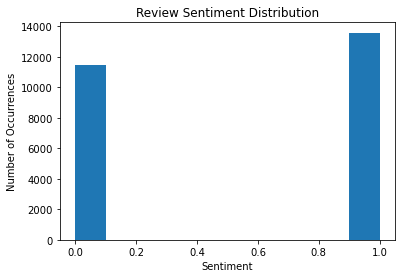

In [9]:
plt.figure()
plt.hist(movies['sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Occurrences')
plt.title('Review Sentiment Distribution')

Looking at the above movies sentiment distribution, we can expect our DummyClassifier to always predict that a movie review's sentiment is "good".

In [10]:
dummy_clf = DummyClassifier().fit(X_train, y_train)
print(f"The DummyClassifier's train score: {dummy_clf.score(X_train, y_train)}")

The DummyClassifier's train score: 0.5423748146458309


In [11]:
# Have the baseline model make predictions
y_pred = dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))

0.5423819028609448


We can visualize the accuracy of our baseline bodel using a confusion matrix.

In [12]:
print(confusion_matrix(y_test, y_pred))

[[   0 3439]
 [   0 4076]]


In [13]:
# Generate confusion matrix
sent_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
sent_df = pd.DataFrame(
    sent_matrix, 
    columns=["Predicted Bad", "Predicted Good"],
    index=["True Bad", "True Good"]
)

display(sent_df)

,Predicted Bad,Predicted Good
True Bad,0,3439
True Good,0,4076


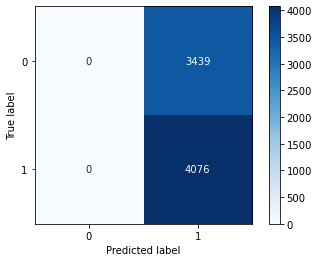

In [14]:
# the function expects the estimator, inputs and target as parameters
plot_confusion_matrix(dummy_clf, X_test, y_test, cmap='Blues');

As expected, because the "good" movie reviews class is the most frequently occurring, our baseline model had an accuracy score of **54%**. In essence, based solely on the distribution of our 2 classes, one can predict that a movie review's sentiment is good 54% of the time. We will use this percentage as a baseline when fitting our machine learning models and disregard any models that perform worse.

### 5. Apply Machine Learning Models with GridSearch

Having established a baseline model for comparison, we can now begin fitting and evaluating our machine learning models. We will apply the models into our a pipeline and use that pipeline within the SKLearn GridSeacrch tool to optimize the hyperparameters. We'll use GridSeachCV to determine which of our following two models has the lowest cross-validation scores while applying both our BagOfWords and TF-IDF vectorizers:
- Logistic Regression
- DecisionTreeClassifier

In [15]:
# First we will create a placeholder for the steps in our machine learning process using a pipeline
estimators = [
    ('transformer', bow_vec),
    ('scaler', StandardScaler()),    
    ('model', LogisticRegression())
]

pipe = Pipeline(estimators)

In [ ]:
# Load in model
fitted_grid = joblib.load('fitted_gridsearch_model.pkl')

**If you wish to manually fit the model to the data, uncomment the following code block (CTRL+/). Otherwise, the model has been loaded in above.**

In [16]:
# %%time
# # Specificy the hyperparameters for each model
# param_grid = [
#     {
#     'transformer': list_of_vecs, 
#     'scaler': [StandardScaler()],    
#     'model': [LogisticRegression()],
#     'model__penalty': ['l2'],
#     'model__C': [0.001, 0.01, 0.1, 1,]
#     },
#     {
#     'transformer': list_of_vecs, 
#     'scaler': [StandardScaler()],
#     'model': [DecisionTreeClassifier()],
#     'model__max_depth': [2, 3, 4]
#     }
# ]

# # Determine the best estimators with GridSearchCV
# grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-2)

# fitted_grid = grid.fit(X_train, y_train)

Wall time: 33min 45s


We can now print the results of our GridSearch to see which model has the best estimators.

In [17]:
print(fitted_grid.best_estimator_)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('bow_vec',
                                                  CountVectorizer(min_df=10,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<function my_tokenizer at 0x0000022F5B1C1E50>),
                                                  'review')])),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.001))])


In [18]:
print(f"The best model's train score: {fitted_grid.score(X_train, y_train)}")

The best model's train score: 0.9984601345956428


### Model Evaluation

We can see that our GridSearchCV determined that the Logistic Regression with a C-value of 0.001 and Bag of Words vectorizer provided our best estimator. We can visualize our actual and predicted values using a Confusion Matrix in the folowing code block.

In [19]:
# use the fitted grid search to make predictions.
y_pred = fitted_grid.predict(X_test)

# Generate confusion matrix
sent_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
sent_df = pd.DataFrame(
    sent_matrix, 
    columns=["Predicted Bad", "Predicted Good"],
    index=["True Bad", "True Good"]
)

display(sent_df)

,Predicted Bad,Predicted Good
True Bad,2938,501
True Good,389,3687


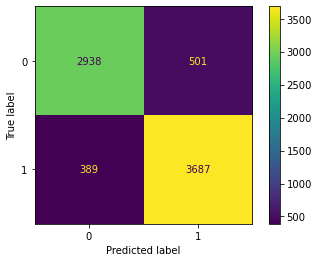

In [20]:
plot_confusion_matrix(fitted_grid, X_test, y_test);

We can interpret the confusion matrix above by using SKLearn's `classification_report` to compute the model's precision, recall and $F_1$ score. With these, we can interpret our model's predictions.

In [21]:
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      3439
           1       0.88      0.90      0.89      4076

    accuracy                           0.88      7515
   macro avg       0.88      0.88      0.88      7515
weighted avg       0.88      0.88      0.88      7515



Based on the classification report for our GridSearchCV's best estimator, we determined the following:
- Of the total 3,327 reviews predicted to be negative, our model correctly predicted 2,938, whereas for the total 4,188 positive reviews, our model correctly predicted 3,687. This gave our model 88% negative and positive precision scores. With this score, we can be relatively confident that our model accurately identifies specific sentiments as actually being "bad" or "good"
- In terms of recall, our model scored 85% for negative prediction and 90% for positive predictions. In essence, of the actual 3,439 negative reviews, our model correctly predicted 2,938 whereas for the actual 4,076 positive reviews, our model correctly predicted 3,687.
- The precision and recall scores together gave our model an 87% $F_1$ score for negative reviews and 89% $F_1$ for positive reviews.
- Overall, our model was **88%** accurate at predicting the correct sentiment behind our test set. It should be noted that there is some significant overfitting to our training set given the model's accuracy on our training set is practically 100%. 

Though we will move forward with our evaluation, it should be noted that to rectify this overfitting, we could increase the size of our test set during our train-test split as a means of avoiding the overfitting.

##### AUC-ROC Curve

As noted earlier in this notebook, the dataset has a relatively balanced distribution therefore another evaluation tool we can use is the AUC-ROC (Area Under the Curve - Receiver Operator Characteristic) curve. This is noteworthy in contrast to an imbalanced dataset where the ROC curve can be easily changed and thus misleading due to a smaller number of correct or incorrect predictions. The AUC-ROC cruve will allow us to determine the optimal True Positive Rate (TPR) and False Positive Rate (FPR) by plotting the different threshold values for classifying our positive class.

In [22]:
# We first determine the probability of predictions
y_proba = fitted_grid.predict_proba(X_test)[:,1]

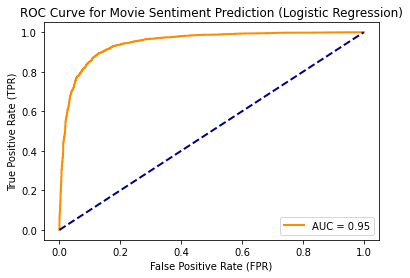

Area under curve (AUC):0.9464140333375092



In [23]:
fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Movie Sentiment Prediction (Logistic Regression)')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

The Area Under the ROC curve measures the probability that our model will rank a positive review as positive and a negative review as negative. In the case of our model, that probabilty is an excellent **94.6%**!

We can now save this fitted model and move forward with applying our last model, the XGBoost.

In [24]:
 # Save best estimator
fitted_gridsearch_model = fitted_grid
joblib.dump(fitted_grid, 'fitted_gridsearch_model.pkl')

['fitted_gridsearch_model.pkl']

### XGBoost

To run our XGBoost, we will use SKLearn's RandomizedSearchCV as opposed to GridSearchCV as we did above. The primary difference is that RandomizedSearchCV will randomly select the combination of hyperparameters upon which we run our model. While the result in parameter settings is similiar, the RandomizedSearchCV run time will be significantly lower.

In [ ]:
# Load in model
fitted_search = joblib.load('randsearch_model_xgb.pkl')

**If you wish to manually fit the model to the data, uncomment the following code block (CTRL+/). Otherwise, the model has been loaded in above.**

In [26]:
# %%time
# # Using RandomizedSearchCV to find the optimal values for XGBoost hyperparameters
# # Setup the pipeline
# estimators2 = [
#     ('transformer', bow_vec),
#     ('scaler', StandardScaler()),
#     ('model', XGBClassifier())
# ]

# pipe2 = Pipeline(estimators2)

# # Define which hyperparameters we want to tune
# param_grid2 = {
#           'transformer': list_of_vecs,
#           'scaler': [StandardScaler()],
#           'model__max_depth': [1, 2, 3, 4],
#           'model__learning_rate': [0.01, 0.1, 0.3],
#           'model__n_estimators': [100, 200]
# }

# # Fit RandomizedSearchCV
# rand_search = RandomizedSearchCV(pipe2, param_grid2, verbose=3, n_jobs=-2)
# fitted_search = rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[22:47:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1h 28min 51s


In [27]:
# Print the optimal hyperparameter values 
print(fitted_search.best_estimator_)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('bow_vec',
                                                  CountVectorizer(min_df=10,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  tokenizer=<function my_tokenizer at 0x0000022F5B1C1E50>),
                                                  'review')])),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.01,
                               ma

In [28]:
print(f"My XGBoost model's train score: {fitted_search.score(X_train, y_train)}")

My XGBoost model's train score: 0.6579217520246379


### Model Evaluation

We can see that our RandomizedSearch determined that the Logistic Regression with a C-value of 0.001 and Bag of Words vectorizer provided our best estimator. We can visualize our actual and predicted values using a Confusion Matrix in the folowing code block.

In [29]:
# use the fitted randomized search to make predictions.
y_pred2 = fitted_search.predict(X_test)

# Generate confusion matrix
sent_matrix = confusion_matrix(y_test, y_pred2)

# label rows and columns
sent_df = pd.DataFrame(
    sent_matrix, 
    columns=["Predicted Bad", "Predicted Good"],
    index=["True Bad", "True Good"]
)

display(sent_df)

,Predicted Bad,Predicted Good
True Bad,1225,2214
True Good,440,3636


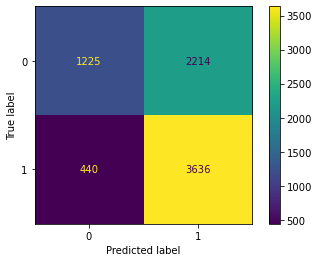

In [30]:
plot_confusion_matrix(fitted_search, X_test, y_test);

We can interpret the confusion matrix above using SKLearn's `classification_report` to compute the model's precision, recall and $F_1$ score.

In [31]:
report_randsearch = classification_report(y_test, y_pred2)
print(report_randsearch)

              precision    recall  f1-score   support

           0       0.74      0.36      0.48      3439
           1       0.62      0.89      0.73      4076

    accuracy                           0.65      7515
   macro avg       0.68      0.62      0.61      7515
weighted avg       0.67      0.65      0.62      7515



Based on the classification report for our RandomSearchCV's best estimator, we can observe the following:
- Of the total 1,665 reviews predicted to be negative, our model correctly predicted 1,225, whereas for the total 5,850 positive reviews, our model correctly predicted 3,636. This gave our model 74% and 62% negative and positive precision scores respectively. This is weaker than the Logistic Regression model signifying that the XGBoost is relatively weaker at correctly predicting whether a review is actually "bad" or "good".
- In terms of recall, our model scored 36% for negative predictions and 89% for positive predictions.  In essence, of the actual 3,439 negative reviews, our model only correctly predicted 1,225 whereas for the actual 4,076 positive reviews, our model correctly predicted 3,636. In contrast to our earlier findings, the lower recall score for XGBoost implies that we would have more False Positive reviews than in our Logistic Regression.
- The precision and recall scores together gave our model a weak 48% $F_1$ score for negative reviews and 73% $F_1$ for positive reviews.
- Overall, ourXGBoost model was **65%** accurate at predicting the correct sentiment behind our test set. While this is higher than our baseline DummyClassifier, it is significantly lower than our GridSearchCV model and will thus me removed from further consideration.

In [34]:
# Save to pickle
randsearch_model_xgb = fitted_search
joblib.dump(randsearch_model_xgb, 'randsearch_model_xgb.pkl')    

['randsearch_model_xgb.pkl']

## Conclusion

Havig fitted and evaluated our model using both GridSearchCV and RandomizedSearchCV, we will be proceed with interpreting the findings of the **Logistic Regression** model in our next notebook. While the Logistic Regression model displayed some overfitting, it was significantly more accurate when predicting "bad" and "good" sentiment in our reviews. As such, the next notebook will explore the results of the best model to determine which words are used by reviewers to express "bad" and "good" sentiment in their reviews.